<a href="https://colab.research.google.com/github/RNF24/Classify-fruit-and-vegetables/blob/main/Model_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [ ]:
!pip install opendatasets
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import Sequence

import opendatasets as od
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import splitfolders
import pandas as pd
import os

import shutil
from PIL import Image

#Download Dataset

In [ ]:
od.download("https://www.kaggle.com/datasets/muhriddinmuxiddinov/fruits-and-vegetables-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rahmanf24
Your Kaggle Key: ··········


100%|██████████| 870M/870M [00:08<00:00, 103MB/s]


#Split Folder

In [ ]:
splitfolders.ratio('/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset(12000)/Fruits',
                   output="/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Fruits/",
                   seed=42,
                   ratio=(0.8,0.1,0.1),
                   group_prefix=None)

Copying files: 5997 files [00:01, 3581.43 files/s]


In [ ]:
splitfolders.ratio('/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset(12000)/Vegetables',
                   output="/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Vegetables",
                   seed=42,
                   ratio=(0.8,0.1,0.1),
                   group_prefix=None)

Copying files: 6003 files [00:02, 2569.53 files/s]


#Merge Train and Test Data for Fruits and Vegetables

Funtion for moving the directory

In [ ]:
def move_dir(src, dest, dir_list):
  for dir_ in dir_list:
    source = os.path.join(src, dir_)

    if os.path.isdir(source):
        shutil.move(source, dest)

In [ ]:
def move_subdir(source, dest, subdir):
  if not os.path.isdir(dest):
      os.mkdir(dest)

  src_path = os.path.join(source, subdir)
  for item_list in os.listdir(src_path):
      src = os.path.join(src_path, item_list)
      dst = os.path.join(dest, item_list)
      shutil.move(src, dst)

  os.rmdir(src_path)

Train Data:

Disini, mengambil train data fruits dan vegetable lalu menggabungkannya menjadi 1 train data

In [ ]:
source_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Fruits'

dir_list = ['train']

dest_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset'
dest = os.path.join(dest_path, 'train')

move_dir(source_path, dest, dir_list)

In [ ]:
source_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Vegetables'

subdir = 'train'

dest_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/train'

move_subdir(source_path, dest_path, subdir)

Validation Data:

Disini, mengambil validasi data fruits dan vegetable lalu menggabungkannya menjadi 1 validasi data

In [ ]:
source_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Fruits'

dir_list = ['val']

dest_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset'
dest = os.path.join(dest_path, 'val')

move_dir(source_path, dest, dir_list)

In [ ]:
source_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Vegetables'

subdir = 'val'

dest_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/val'

move_subdir(source_path, dest_path, subdir)

Test Data:

Disini, mengambil validasi data fruits dan vegetable lalu menggabungkannya menjadi 1 test data

In [ ]:
source_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Fruits'

dir_list = ['test']

dest_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset'
dest = os.path.join(dest_path, 'test')

move_dir(source_path, dest, dir_list)

In [ ]:
source_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Vegetables'

subdir = 'test'

dest_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/test'

move_subdir(source_path, dest_path, subdir)

#Assign

In [ ]:
train_FileNames = os.path.join('/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/train')
val_FileNames = os.path.join('/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/val')
test_FileNames = os.path.join('/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/test')

Convert the RGBA

In [ ]:
directory = "/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset"

for root, _, files in os.walk(directory):
    for file in files:
        if file.endswith(".png") or file.endswith(".webp"):
            image_path = os.path.join(root, file)

            with Image.open(image_path) as img:
                if img.mode == "P" and "transparency" in img.info:
                    img = img.convert("RGBA")

                save_path = os.path.splitext(image_path)[0] + ".png"
                if file.endswith(".webp"):
                    save_path = os.path.splitext(image_path)[0] + ".jpg"

                img.save(save_path)

#Model

In [ ]:
from tensorflow.keras.applications import Xception

def create_pre_trained():
  pre_trained_model =Xception(input_shape = (150, 150, 3),
                                  include_top = False,
                                  weights = 'imagenet',
                                  pooling ='max',
                                  classes = 20)

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained()

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

num_classes = 20

def create_final_model(pre_trained_model, num_classes):
  x = layers.Flatten()(pre_trained_model.output)
  x = layers.Dense(216, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=pre_trained_model.input, outputs=x)

  return model

In [ ]:
model = create_final_model(pre_trained_model, num_classes)

#Normalization

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   brightness_range=(0.2, 0.8),
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_FileNames,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_FileNames,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 9582 images belonging to 20 classes.
Found 1192 images belonging to 20 classes.


#Adjust Learning Training

In [ ]:
def adjust_learning_rate():
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=["accuracy"])

    history = model.fit(train_generator, epochs=100, callbacks=[lr_schedule])

    return history

In [ ]:
lr_history = adjust_learning_rate()

Epoch 1/100
480/480 [==============================] - 125s 236ms/step - loss: 3.1251 - accuracy: 0.0494 - lr: 1.0000e-06
Epoch 2/100
480/480 [==============================] - 114s 237ms/step - loss: 3.0810 - accuracy: 0.0533 - lr: 1.1220e-06
Epoch 3/100
480/480 [==============================] - 113s 236ms/step - loss: 3.0538 - accuracy: 0.0535 - lr: 1.2589e-06
Epoch 4/100
480/480 [==============================] - 119s 248ms/step - loss: 3.0247 - accuracy: 0.0620 - lr: 1.4125e-06
Epoch 5/100
480/480 [==============================] - 114s 237ms/step - loss: 2.9855 - accuracy: 0.0742 - lr: 1.5849e-06
Epoch 6/100
480/480 [==============================] - 113s 236ms/step - loss: 2.9615 - accuracy: 0.0810 - lr: 1.7783e-06
Epoch 7/100
480/480 [==============================] - 113s 235ms/step - loss: 2.9281 - accuracy: 0.0964 - lr: 1.9953e-06
Epoch 8/100
480/480 [==============================] - 114s 237ms/step - loss: 2.8945 - accuracy: 0.1121 - lr: 2.2387e-06
Epoch 9/100
480/480 [===

(1e-06, 10.0, 0.0, 10.0)

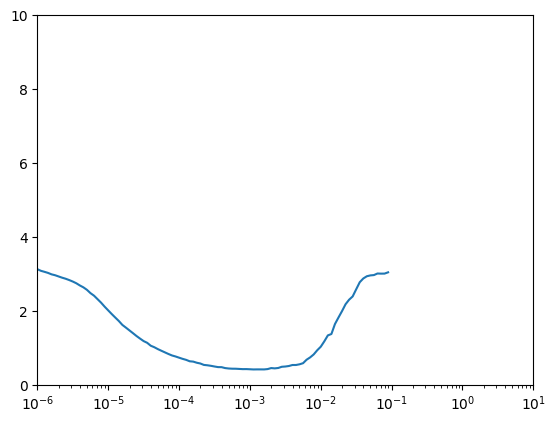

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 10, 0, 10])

#Compile and Train the model

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=3.5481e-04, momentum=0.9),
                metrics=['accuracy'])

In [ ]:
EPOCHS = 20

history = model.fit(
      train_generator,
      batch_size = 20,
      steps_per_epoch=480,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=59.6,
      verbose=2)

Epoch 1/20
480/480 - 130s - loss: 1.8387 - accuracy: 0.4598 - val_loss: 0.9005 - val_accuracy: 0.7299 - 130s/epoch - 271ms/step
Epoch 2/20
480/480 - 114s - loss: 1.1132 - accuracy: 0.6571 - val_loss: 0.6839 - val_accuracy: 0.7928 - 114s/epoch - 237ms/step
Epoch 3/20
480/480 - 115s - loss: 0.9265 - accuracy: 0.7175 - val_loss: 0.6013 - val_accuracy: 0.8196 - 115s/epoch - 240ms/step
Epoch 4/20
480/480 - 113s - loss: 0.8335 - accuracy: 0.7400 - val_loss: 0.5612 - val_accuracy: 0.8247 - 113s/epoch - 236ms/step
Epoch 5/20
480/480 - 112s - loss: 0.7754 - accuracy: 0.7592 - val_loss: 0.5239 - val_accuracy: 0.8414 - 112s/epoch - 234ms/step
Epoch 6/20
480/480 - 113s - loss: 0.7270 - accuracy: 0.7753 - val_loss: 0.4863 - val_accuracy: 0.8414 - 113s/epoch - 235ms/step
Epoch 7/20
480/480 - 118s - loss: 0.6800 - accuracy: 0.7824 - val_loss: 0.4816 - val_accuracy: 0.8423 - 118s/epoch - 245ms/step
Epoch 8/20
480/480 - 116s - loss: 0.6469 - accuracy: 0.7989 - val_loss: 0.4492 - val_accuracy: 0.8482 - 

# Check train and val performance

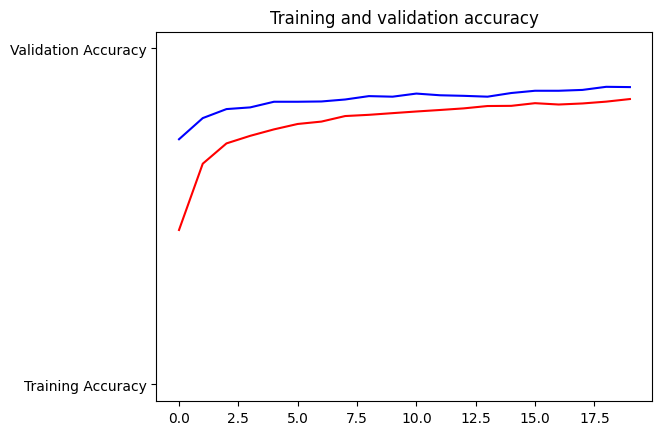

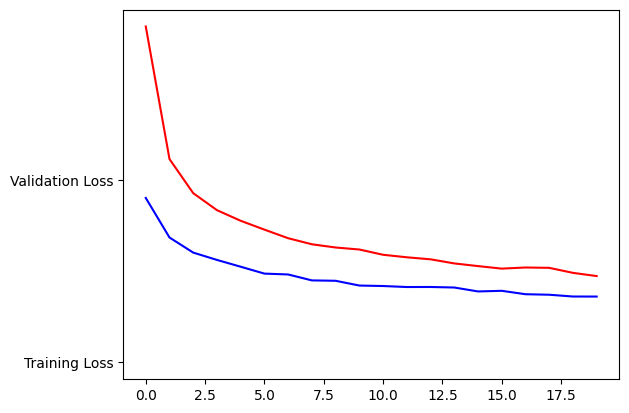

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

#Testing data

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_FileNames,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=False)

loss, accuracy = model.evaluate(test_generator)

print("Test accuracy:", accuracy)

Found 1216 images belonging to 20 classes.
61/61 [==============================] - 14s 199ms/step - loss: 0.4163 - accuracy: 0.8692
Test accuracy: 0.8692434430122375


#Make F1 table and Confusion Matrix

In [ ]:
y_pred = model.predict(test_generator)
predicted_labels = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

tp = np.sum(np.logical_and(y_true == 1, predicted_labels == 1))
fp = np.sum(np.logical_and(y_true == 0, predicted_labels == 1))
tn = np.sum(np.logical_and(y_true == 0, predicted_labels == 0))
fn = np.sum(np.logical_and(y_true == 1, predicted_labels == 0))

data = {
    'Actual Positive': [tp, fn],
    'Actual Negative': [fp, tn]
}

index = ['Predicted Positive', 'Predicted Negative']
f1_table = pd.DataFrame(data, index=index)

print(f1_table)

61/61 [==============================] - 9s 142ms/step
                    Actual Positive  Actual Negative
Predicted Positive               58                0
Predicted Negative                0               44


#Save model

In [ ]:
#Save to H5 format
model.save("model_freshgrocie.h5")

In [ ]:
#Save to TFLite format
saved_model = tf.keras.models.load_model("model_freshgrocie.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)

model_convert = converter.convert()
file_convert = open ("model_freshgrocie.tflite", "wb")
file_convert.write(model_convert)

68396428

In [ ]:
#Save to tfjs format
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [ ]:
import tensorflowjs as tfjs

saved_model = tf.keras.models.load_model("model_freshgrocie.h5")

tfjs.converters.save_keras_model(saved_model, '/content')

#Making the txt data

In [ ]:
dataset_dir = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset'

subdirectories = sorted(os.listdir(dataset_dir))

class_names = []
for subdir in subdirectories:
    subdir_path = os.path.join(dataset_dir, subdir)
    if os.path.isdir(subdir_path) and len(os.listdir(subdir_path)) > 0:
        class_directories = sorted(os.listdir(subdir_path))
        class_names.extend(class_directories)

class_names = sorted(list(set(class_names)))

label_mapping = {
    'FreshApple': 'Fresh Apple',
    'FreshBanana': 'Fresh Banana',
    'FreshBellpepper' : 'Fresh Bellpepper',
    'FreshCarrot' : 'Fresh Carrot',
    'FreshCucumber' : 'Fresh Cucumber',
    'FreshMango' : 'Fresh Mango',
    'FreshOrange' : 'Fresh Orange',
    'FreshPotato' : 'Fresh Potato',
    'FreshStrawberry' : 'Fresh Strawberry',
    'FreshTomato' : 'Fresh Tomato',
    'RottenApple': 'Rotten Apple',
    'RottenBanana': 'Rotten Banana',
    'RottenBellpepper' : 'Rotten Bellpepper',
    'RottenCarrot' : 'Rotten Carrot',
    'RottenCucumber' : 'Rotten Cucumber',
    'RottenMango' : 'Rotten Mango',
    'RottenOrange' : 'Rotten Orange',
    'RottenPotato' : 'Rotten Potato',
    'RottenStrawberry' : 'Rotten Strawberry',
    'RottenTomato' : 'Rotten Tomato'
}

with open('labels_class.txt', 'w') as f:
    for class_name in class_names:
      if class_name in label_mapping:
          new_class_name = label_mapping[class_name]
      else:
          new_class_name = class_name

      f.write(new_class_name + '\n')